# Can there be four times of sign reversals in AEM data?

**Author**: [Seogi Kang](https://github.com/sgkang)

This notebook was prompted to explain the observation of AEM data, which showed four times of sign reversals (by Burke Minsely at AEM workshop 2018). 

In [1]:
from SimPEG import *
from SimPEG import EM
from scipy.constants import mu_0
import numpy as np
import scipy.sparse as sp
from simpegEMIP.StretchedExponential import SEInvImpulseProblem, SESurvey
import matplotlib.pyplot as plt
from pymatsolver import PardisoSolver
import matplotlib.patches as mpatches
from matplotlib.collections import PatchCollection
def rect2D(p1, p2):    
    xy = np.c_[np.r_[p1[0], p2[0], p2[0], p1[0], p1[0]], np.r_[p1[1], p1[1], p2[1], p2[1], p1[1]]]
    return xy
%matplotlib inline

In [2]:
import matplotlib 
matplotlib.rcParams["font.size"] = 14
figdir = "../figures/"

## Step1: Generate 2D Cylindrical Mesh

In [3]:
cs, ncx, ncz, npad = 10., 40, 40, 25
hx = [(cs,ncx), (cs,npad,1.3)]
hz = [(cs,npad,-1.3), (cs,ncz), (cs,npad,1.3)]
mesh = Mesh.CylMesh([hx,1,hz], '00C')    

## Step2: Generate conductivity and chargeability model

In [4]:
layer_ind = (mesh.gridCC[:,2]<0)&(mesh.gridCC[:,2]>-10)

sig_1 = 0.001
sig_2 = 0.01
sigmaInf = np.ones(mesh.nC) * sig_1
sigmaInf[layer_ind] = 0.001
airind = mesh.gridCC[:,2]>0.
z = 0.
radius = 200.
z_top = -150
z_bottom = -200
blkind  = np.logical_and(mesh.gridCC[:,0]<radius, (mesh.gridCC[:,2]<z_top)&(mesh.gridCC[:,2]>z_bottom))
sigmaInf[airind] = 1e-8
sigmaInf[blkind] = sig_2
eta_se, tau_se, c_se = 0.2, 0.02, 0.7
eta = np.zeros(mesh.nC)
eta[blkind] = eta_se
eta[layer_ind] = 0.9
tau = np.ones(mesh.nC) * tau_se
c = np.ones(mesh.nC) * c_se
tau[layer_ind] = 0.0004
c[layer_ind] = 0.7

## Step3: Generate `Problem` and `Survey`

In [5]:
from simpegEMIP.TDEM import Problem3D_e, Problem3DEM_e, Rx, Survey

In [6]:
rxloc = np.array([[0., 0., 30.]])
srcloc = np.array([[0., 0., 30.]])

rx_emip = Rx.Point_dbdt(rxloc, np.logspace(np.log10(1e-5), np.log10(0.5), 51), 'z')
src_emip = EM.TDEM.Src.CircularLoop([rx_emip], waveform=EM.TDEM.Src.StepOffWaveform(), loc=srcloc, radius = 13.)
survey_emip = Survey([src_emip])
prb_emip = Problem3D_e(mesh, sigmaInf=sigmaInf, eta=eta, tau=tau, c=c)
prb_emip.timeSteps = [(1e-06, 5), (2.5e-06, 5), (5e-06, 5), (1e-05, 5), (2e-05, 5), (4e-05, 5), (8e-05, 5), (1.6e-04, 5), (4e-04, 5), (8e-04, 5), (1e-03, 5), (2e-03, 5), (4e-03, 5), (8e-03, 5), (1e-02, 5), (2e-02, 5), (4e-02, 5), (8e-02, 5), (1e-01, 5)]
prb_emip.Solver = PardisoSolver
prb_emip.pair(survey_emip)
m = np.r_[sigmaInf, eta, tau, c]
F = prb_emip.fields(m)
data = survey_emip.dpred(m, f=F)

/Users/sgkang/Projects/simpeg/SimPEG/Props.py:400: UserWarning: Cannot add model as there are no active mappings, choose from: ['cMap', 'etaMap', 'rhoMap', 'sigmaInfMap', 'sigmaMap', 'tauMap']
  "', '".join(self._all_map_names)


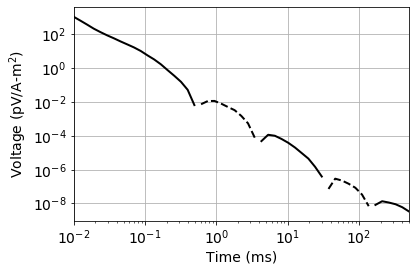

In [7]:
from simpegEMIP.TDEM.Utils import get_dobs_pn
moment = np.pi*src_emip.radius**2 / 1e12
rectpts = rect2D([0.2, 1e-14/moment],[3., 1e-6/moment])
fig, ax = plt.subplots(1,1, figsize = (6, 4))
ms = 1e3
data_p, data_n = get_dobs_pn(data.flatten()/moment)
ax.loglog(rx_emip.times*ms, data_n, 'k-', lw=2)
ax.loglog(rx_emip.times*ms, data_p, 'k--', lw=2)
ax.set_xlabel("Time (ms)")    
ax.set_xlim(rx_emip.times.min()*ms, rx_emip.times.max()*ms)
ax.grid(True)
# ax.set_ylim(1e-8, 1e3)
ax.set_ylabel("Voltage (pV/A-m$^2$)")
plt.tight_layout()

In [8]:
rx_em = Rx.Point_dbdt(rxloc, np.logspace(np.log10(1e-5), np.log10(0.5), 51), 'z')
src_em = EM.TDEM.Src.CircularLoop([rx_em], waveform=EM.TDEM.Src.StepOffWaveform(), loc=srcloc, radius = 13.)
survey_em = Survey([src_em])
prb_em = Problem3DEM_e(mesh, sigma=sigmaInf)
prb_em.timeSteps = [(1e-06, 5), (2.5e-06, 5), (5e-06, 5), (1e-05, 5), (2e-05, 5), (4e-05, 5), (8e-05, 5), (1.6e-04, 5), (4e-04, 5), (8e-04, 5), (1e-03, 5), (2e-03, 5), (4e-03, 5), (8e-03, 5), (1e-02, 5), (2e-02, 5), (4e-02, 5), (8e-02, 5), (1e-01, 5)]
prb_em.Solver = PardisoSolver
prb_em.pair(survey_em)
m = np.r_[sigmaInf, eta, tau, c]
F_em = prb_em.fields(m)
data_em = survey_em.dpred(m, f=F_em)
data_ip = data - data_em

/Users/sgkang/Projects/simpeg/SimPEG/Props.py:400: UserWarning: Cannot add model as there are no active mappings, choose from: ['rhoMap', 'sigmaMap']
  "', '".join(self._all_map_names)


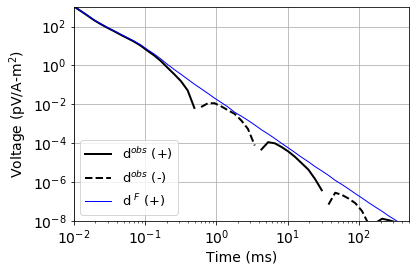

In [9]:
from simpegEMIP.TDEM.Utils import get_dobs_pn
moment = np.pi*src_emip.radius**2 / 1e12
rectpts = rect2D([0.2, 1e-14/moment],[3., 1e-6/moment])
fig, ax = plt.subplots(1,1, figsize = (6, 4))
ms = 1e3
data_p, data_n = get_dobs_pn(data.flatten()/moment)
data_ip_p, data_ip_n = get_dobs_pn(data_ip.flatten()/moment)
ax.loglog(rx_emip.times*ms, data_n, 'k-', lw=2)
ax.loglog(rx_emip.times*ms, data_p, 'k--', lw=2)
ax.loglog(rx_emip.times*ms, -data_em.flatten()/moment, 'b-', lw=1)
ax.legend(("d$^{obs}$ (+)", "d$^{obs}$ (-)", "d$^{\ F}$ (+)","d$^{IP}$ (+)", "d$^{IP}$ (-)"), fontsize = 13, loc=3)
ax.set_xlabel("Time (ms)")    
ax.set_xlim(rx_emip.times.min()*ms, rx_emip.times.max()*ms)
ax.grid(True)
ax.set_ylim(1e-8, 1e3)
ax.set_ylabel("Voltage (pV/A-m$^2$)")
plt.tight_layout()
# fig.savefig(figdir+"data", dpi=300)